In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from time_series_utils import WindowGen    

In [2]:
cols= ['time','missing_info','job_id','task_index','machineid','event_type','user','sch_class',
       'priority','cpu_req','mem_req','disk_req','machine_restr']

n_files = 200
try:
    df = pd.read_csv(f'data_{n_files}.zip',index_col=0)
except:
    print('Loading new data...')
    data= pd.DataFrame()
    for i in range(n_files):
        try:
            df = pd.read_csv('data/'+sorted(os.listdir('data'))[i],names=cols)
            df[['job_id','task_index']] = df[['job_id','task_index']].astype(str)
            df['n_tasks'] = df['job_id']+df['task_index']
            df['slot']=df['time']//120000000
            df = df[['slot','n_tasks','cpu_req','mem_req']].drop_duplicates('n_tasks')
            df = df.groupby('slot',as_index=True).agg({"n_tasks": 'count',"cpu_req": np.sum,'mem_req': np.sum})
            data = pd.concat([data,df],axis=0)
        except:
            continue
    df = data.reset_index(drop=True)
    df.to_csv(f'data_{n_files}.zip')
    print('Data is loaded.')


In [3]:
# Data Transformations
df_proc = df
df_proc['n_tasks'] = np.log(df_proc['n_tasks'])

def norm(series):
    mean = series.mean()
    std = series.std()
    return (series-mean)/std

In [4]:
# Split data into train and test sets
n_samples = df.shape[0]
split = 0.1

train_df = df_proc[:round(n_samples*(1-split))]
test_df = df_proc[:round(n_samples*(1-split))]

In [5]:
train_df = train_df.apply(norm, axis=1)
test_df = test_df.apply(norm, axis=1)

In [6]:
# Reshape data according to a given window
step = 60
window = WindowGen(step)

X_train, y_train = window(train_df,column_names=['n_tasks'],label_names=['n_tasks'])
X_test, y_test = window(test_df,column_names=['n_tasks'],label_names=['n_tasks'])

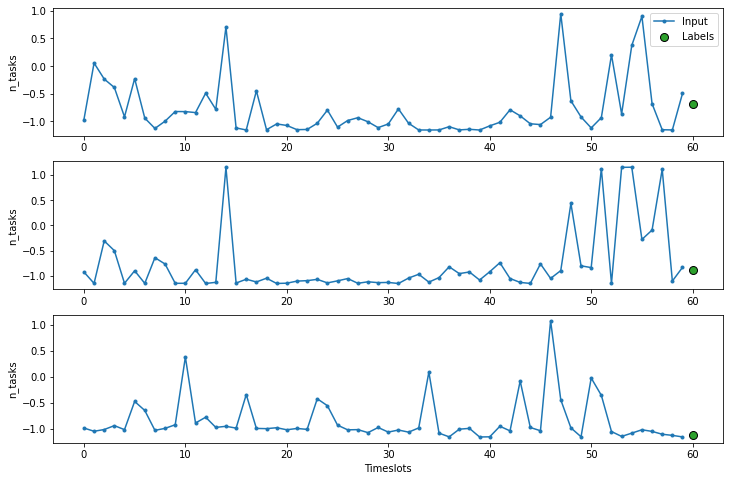

In [7]:
window.plot(plt_col='n_tasks')

In [8]:
import tensorflow as tf
import tensorflow_addons as tfa
import datetime
from tensorflow.keras import regularizers
import keras_tuner as kt
from tuner import HpModel

%load_ext tensorboard

In [9]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './tmp/checkpoint',
    save_weights_only=True,
    monitor='loss',
    save_best_only=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# early_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,
#     patience=30)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

loss = tf.keras.losses.MeanSquaredError()
EPOCHS = 1000

In [10]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(step,1)))
    LSTM1 = hp.Int('units1', min_value=50, max_value=500, step=50)
    LSTM2 = hp.Int('units2', min_value=20, max_value=60, step=10)
    model.add(tf.keras.layers.LSTM(units=LSTM1,return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=LSTM1))
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [13]:
model = HpModel(model=model_builder,loss=loss,epochs=EPOCHS)

tuner = kt.RandomSearch(objective=kt.Objective("my_metric", "min"), max_trials=5, hypermodel=model,
    directory="results", project_name="custom_training", overwrite=True,)

In [14]:
tuner.search(x=X_train, y=y_train, validation_data=(X_test, y_test))

Trial 1 Complete [00h 03m 30s]
my_metric: 0.10922393202781677

Best my_metric So Far: 0.10922393202781677
Total elapsed time: 00h 03m 30s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
units1            |500               |50                
units2            |30                |30                
batch_size        |4500              |2000              
learning_rate     |0.0057008         |0.001             

Epoch: 0


InternalError:    Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 1, 500, 1, 60, 4500, 500] 
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_run_train_step_57383]

Function call stack:
run_train_step -> run_train_step -> run_train_step


In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
fin = model.predict(X_train)

In [ ]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(fin,y_train)
print('Root mean squared loss is: ', m.result().numpy())

In [ ]:
y_train=y_train.reshape(-1)
y_test=y_test.reshape(-1)
fin= fin.reshape(-1)

m = tfa.metrics.r_square.RSquare()
m.update_state(fin, y_train)
print('R-squared is: ', m.result().numpy())

In [ ]:
fin

In [ ]:
y_train

In [ ]:
y_train_e=np.exp(y_train)
fin_e=np.exp(fin)

In [ ]:
y_pred = pd.DataFrame({'slot':[i for i in range(len(fin))],'Class':['Prediction' for i in range(len(fin))],'mem_req':fin_e})
y_true = pd.DataFrame({'slot':[i for i in range(len(fin))],'Class':['True' for i in range(len(fin))],'mem_req':y_train_e})
final = pd.concat([y_pred,y_true], axis=0)

In [ ]:
sns.lineplot(x='slot',y= 'mem_req', ci=None, 
             hue='Class', data=final.reset_index())